### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import seaborn as sns
import pandas as pd
import shutil
import random
import warnings
from sklearn import preprocessing
import itertools

### Paths
After downloading the files from the link: 
change the path accordingly, and leave \painting-to-artist\dataset or \painting-to-artist\workspace as is.

In [16]:
dataset_path = os.path.abspath(r'D:\Program Files (x86)\painting-to-artist\small_dataset')
training_path = os.path.abspath(r'D:\Program Files (x86)\painting-to-artist\small_workspace\train')
testing_path = os.path.abspath(os.path.join(r'D:\Program Files (x86)\painting-to-artist\small_workspace\test'))

### Sampling the Images

In [17]:
def sample_images(data_path, train_path, test_path, n, ratio=0.8):
    """
    This method samples the images from the dataset path to the training path and testing path.
    :param data_path: The path to the data.
    :param train_path: The path to which the training images will be copied.
    :param test_path: The path to which the testing images will be copied.
    :param n: The number of images aimed to be sampled.
    :param ratio: The wanted ratio from the sampled data to be used for training. The rest will be used for testing.
    :return: None
    """

    if ratio >= 1 or ratio <= 0:
        raise ValueError("The ratio should be between 0 and 1 (non-inclusive)")
    
    if ratio < 0.5:
        warnings.warn("The ratio is less than 0.5, not advised for good training")
    
    artists = os.listdir(data_path) # list of artists
    
    for artist in artists:
        artist_path = os.path.join(data_path, artist)  # path to the artist
        images = os.listdir(artist_path)               # list of images
        random.shuffle(images)                         # shuffle the images inside the images list

        ## Adjust the number of images based on availability
        n_train = min(int(n * ratio), int(len(images) * ratio))  # 80% of the images
        n_test = min(n-n_train, len(images) - n_train)           # 20% of the images

        ## Partition the images to training and testing
        train_images = images[:n_train]
        test_images = images[n_train:n_train + n_test]

        ## Create the directories for training and testing
        artist_train_path = os.path.join(train_path, artist)
        artist_test_path = os.path.join(test_path, artist)
        os.makedirs(artist_train_path, exist_ok=True)
        os.makedirs(artist_test_path, exist_ok=True)

        # Create the directories
        for image in train_images:
            image_path = os.path.join(artist_path, image)
            shutil.copy(image_path, os.path.join(artist_train_path, image))

        for image in test_images:
            image_path = os.path.join(artist_path, image)
            shutil.copy(image_path, os.path.join(artist_test_path, image))

In [20]:
# ??????????????????????? #
sample_images(dataset_path, training_path, testing_path, 30, 0.8)

In [21]:
def clear_files(directory):
    """
    Clears all files within the subdirectories of the given directory.
    :param directory: The directory to clear its subcategories' files.
    """
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

### Data Preprocessing
This section includes methods used to preprocess the data before feeding it to the model of our choice.
The result will be a list of vectorized images and their corresponding labels.

In [22]:
def resize_and_split(train_path, test_path, size=128):
    """
    Resizes the images to the given size and splits the data into training and testing datasets.
    :param train_path: The path from which the training images will be taken.
    :param test_path: The path from which the testing images will be taken.
    :param size: The row/column size to which the images will be resized.
    :return: Lists of the training and testing images and their corresponding labels.
    """
    train_images = []
    train_labels = []
    
    # The following loop reads the images from the training path, resizes them, and adds them to the list of images.
    # It also adds the corresponding label for each image to the list of labels.
    for directory_path in glob.glob(train_path+r'/*'):
        label = directory_path.split("\\")[-1] # extracts the artist name from the directory path.
        # print(label)
        for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) # Read the image in color (BGR format)
            img = cv2.resize(img, (size, size))          # Resize the image to the given size, using weighted average values for interpolation.
            train_images.append(img)   # Add the processed image to the list of images
            train_labels.append(label) # Add the label to the list of labels, matching the image in the same index in the images list.
    
    # Convert the lists to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    
    ##################
    
    test_images = []
    test_labels = []

    # The following loop reads the images from the training path, resizes them, and adds them to the list of images.
    # It also adds the corresponding label for each image to the list of labels.
    for directory_path in glob.glob(test_path+r'/*'):
        label = directory_path.split("\\")[-1] # extracts the artist name from the directory path.
        # print(label)
        for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
            img = cv2.imread(img_path, cv2.IMREAD_COLOR) # Read the image in color (BGR format)
            img = cv2.resize(img, (size, size))          # Resize the image to the given size, using weighted average values for interpolation.
            test_images.append(img)    # Add the processed image to the list of images
            test_labels.append(label)  # Add the label to the list of labels, matching the image in the same index in the images list.
            
    # Convert the lists to numpy arrays
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    return train_images, train_labels, test_images, test_labels

In [23]:
# ??????????????????????? #
x_train, y_train, x_test, y_test = resize_and_split(training_path, testing_path, 128)

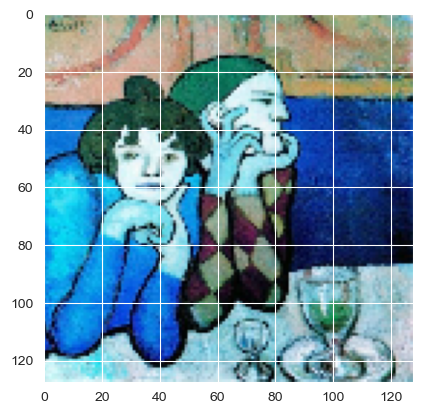

In [24]:
# This code is used to print a resized picture as an example.
plt.imshow(x_train[0])

In [25]:
def label_data(train_labels, test_labels):    
    """
    Converts the labels to numbers for the model to be able to process them, utilizing sklearn LabelEncoder.
    :param train_labels: The labels of the images in the training dataset.
    :param test_labels: The labels of the images in the testing dataset.
    :return: The encoded labels for both the training and testing datasets.
    """
    # Converting the labels to numbers for the model to be able to process them.
    le = preprocessing.LabelEncoder()
    le.fit(test_labels)
    test_labels_encoded = le.transform(test_labels)
    le.fit(train_labels)
    train_labels_encoded = le.transform(train_labels)

    # Giving our data conventional names for easier use in the model.
    return train_labels_encoded, test_labels_encoded

In [26]:
# ??????????????????????? #
y_train_encoded, y_test_encoded = label_data(y_train, y_test)

In [27]:
def minmax_normalize(train_images, test_images):    
    """
    Normalizes the data to be between 0 and 1 using the min-max normalization.
    :param train_images: The training dataset.
    :param test_images: The testing dataset.
    :return: Normalized training and testing datasets.
    """
    train_images_normalized = []
    for img in train_images:
        min_val = np.min(img)
        max_val = np.max(img)
        normalized_img = (img.astype(np.float32) - min_val) / (max_val - min_val)
        train_images_normalized.append(normalized_img)

    test_images_normalized = []
    for img in test_images:
        img = img.astype(np.float32)
        min_val = np.min(img)
        max_val = np.max(img)
        normalized_img = (img.astype(np.float32) - min_val) / (max_val - min_val)
        test_images_normalized.append(normalized_img)
        
    return np.array(train_images_normalized), np.array(test_images_normalized)

In [28]:
# ??????????????????????? #
x_train, x_test = minmax_normalize(x_train, x_test)

In [37]:
def vector_images(dataset):
    """
    Vectorizes the images in the dataset into 1D arrays.
    :param dataset: The dataset of images to be vectorized.
    :return: The vectorized images.
    """
    vectorized_images = []
    for img in dataset:
        vectorized_img = img.reshape(-1)
        vectorized_images.append(vectorized_img)
    return np.array(vectorized_images)

In [38]:
def create_gabor_filter(freq, orient, aspect, std_dev, phase_offset, kernel_size):
    """
    Creates a Gabor filter based on the given parameters.
    :param freq: The frequency of the sine component.
    :param orient: The orientation of the filter.
    :param aspect: The spatial aspect ratio of the filter.
    :param std_dev: The standard deviation of the filter.
    :param phase_offset: The phase offset of the filter.
    :param kernel_size: The kernel size of the filter (K x K).
    :return: A Gabor filters list over all possible combinations of the given parameters.
    """
    combos = list(itertools.product(freq, orient, aspect, std_dev, phase_offset, kernel_size)) # All possible combinations of the filter parameters
    filters = []
    
    for freq, orient, aspect, std_dev, phase_offset, kernel_size in combos:
        gabor_filter = cv2.getGaborKernel((kernel_size, kernel_size), std_dev, orient, freq, aspect, phase_offset, ktype=cv2.CV_32F)
        filters.append(gabor_filter)
    
    return filters

In [39]:
# This function takes a dataset of images and a list of Gabor filters, and applies the filters to the images.
# The result is a list of images filters by each individual filter.
def gabor_images(filter_list, dataset):
    """
    Applies the Gabor filters to the images in the dataset.
    :param filter_list: The list of Gabor filters to be applied to the images.
    :param dataset: The dataset of images to be filtered.
    :return: A list of images filtered by each individual filter.
    """
    gabor_images_dict = {}
    count = 1
    
    # This loop applies the Gabor filters to the images in the dataset and adds the filtered images to the list of filtered images.
    for filt in filter_list:    
        
        curr_gabor_images = []

        gabor_label = 'Gabor' + str(count)
        for img in dataset:
            
            gabor_image = cv2.filter2D(img, cv2.CV_32F, filt)
            filtered_image = gabor_image.reshape(-1)
            curr_gabor_images.append(filtered_image)
        
        gabor_images_dict[gabor_label] = curr_gabor_images
        count += 1

    return gabor_images_dict

In [61]:
def sobel_images(kernel_sizes, dataset):
    """
    Applies the Sobel filter to the images in the dataset.
    :param kernel_sizes: The kernel size of the Sobel filter.
    :param dataset: The dataset of images to be filtered.
    :return: The filtered images.
    """
    sobel_images_dict = {}   # A dictionary to store the filtered images
    count = 1                 # A counter to label the Sobel images for each kernel size
    
    for kernel_size in kernel_sizes:
        
        curr_sobel_images = []              # A list to store the filtered images for the current kernel size
        sobel_label = 'Sobel' + str(count)  # A label for the Sobel images for the current kernel size
        
        for img in dataset:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                       # Convert the image to grayscale
            blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)  # Apply Gaussian smoothing to the grayscale image
        
            edge_sobel_x = cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0, kernel_size) # Apply the x-axis Sobel filter to the smoothed grayscale image
            edge_sobel_y = cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1, kernel_size) # Apply the y-axis Sobel filter to the smoothed grayscale image
        
            edge_sobel = cv2.magnitude(edge_sobel_x, edge_sobel_y)             # Calculate the magnitude of the Sobel filter in both axes
            edge_sobel = edge_sobel.reshape(-1)                                # Reshape the filtered image to a 1D array
        
            curr_sobel_images.append(edge_sobel) # Add the filtered image to the list of filtered images
        
        sobel_images_dict[sobel_label] = curr_sobel_images # Add the list of filtered images to the dictionary of filtered images
        count += 1  # Increment the counter for the next label.
        
    return sobel_images_dict

In [75]:
# The following function is used to vectorize the images by extracting features from them, and aligning them in a dataframe.
# The input must be a 4 dimensional array. In our case, an array of colored images. Won't work with grayscale images.
def feature_extraction(dataset):
    
    # The following parameters are used to create the Gabor filters.
    f  = [1.0] # Represents the frequency of the sine component
    o  = [90] # Represents the orientation of the filter
    sa = [0.5]          # Represents the spatial aspect ratio of the filter.
    sd = [1.0]           # Represents the standard deviation of the filter
    p  = [0]            # Represents the phase offset of the filter
    ks = [3, 7]                 # Represents the kernel size of the filter (K x K)

    flat_images = vector_images(dataset) # Vectorize the images in the dataset
    filters = create_gabor_filter(f, o, sa, sd, p, ks) # Create the Gabor filters based on the parameters above
    gabor_images_lists = gabor_images(filters, dataset) # Apply the Gabor filters to the images in the dataset
    sobel_images_lists = sobel_images(ks, dataset) # Apply the Sobel filter to the images in the dataset

    # Initialize a list to store DataFrames
    dfs_to_concat = []
    
    # Create a DataFrame for the original images
    original_df = pd.DataFrame(flat_images)
    original_df.columns = [f'original_{i}' for i in range(len(original_df.columns))]  # Rename columns
    dfs_to_concat.append(original_df)  

    # Concatenate Gabor filtered images
    for key, gabor_images_list in gabor_images_lists.items():
        gabor_df = pd.DataFrame(gabor_images_list)
        gabor_df.columns = [f'{key}_{i}' for i in range(len(gabor_df.columns))]  # Rename columns
        dfs_to_concat.append(gabor_df)

    # Concatenate Sobel filtered images
    for key, sobel_images_list in sobel_images_lists.items():
        sobel_df = pd.DataFrame(sobel_images_list)
        sobel_df.columns = [f'{key}_{i}' for i in range(len(sobel_df.columns))]  # Rename columns
        dfs_to_concat.append(sobel_df)

    # Concatenate all DataFrames in the list
    features_df = pd.concat([pd.DataFrame(flat_images)] + dfs_to_concat, axis=1)

    print(features_df.columns)

    return features_df

In [76]:
# ??????????????????????? #
img_features = feature_extraction(x_train)

Index([             0,              1,              2,              3,
                    4,              5,              6,              7,
                    8,              9,
       ...
       'Sobel2_16374', 'Sobel2_16375', 'Sobel2_16376', 'Sobel2_16377',
       'Sobel2_16378', 'Sobel2_16379', 'Sobel2_16380', 'Sobel2_16381',
       'Sobel2_16382', 'Sobel2_16383'],
      dtype='object', length=229376)
